# SentencePiece VS Huggingface tokenizer

한국어 서브워드 분절 알고리즘 실습&비교

220527

고우영

| 학습시간 비교(s) | 8000   | 16000 | 32000 | 64000 | 128000|
|------|------|------|------|------|------|
|   Sentencepiece  | 11| 22 |48| 110 |282|
|   hugging_face  | 10| 11 |11| 12 |12|

| 추론시간 비교(s) | 8000| 128000|
|------|------|------|
|   Sentencepiece  | 4.5| 4.93 |
|   hugging_face  | 4.9| 4.97 |

# NSMC 데이터셋 로드
## 15만 문장, 113만 word(띄어쓰기 기준), 평균 7.5word/sentence

[('굳 ㅋ', 1), ('GDNTOPCLASSINTHECLUB', 0)]
data loading done!
sentence: ['굳 ㅋ', 'GDNTOPCLASSINTHECLUB', '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아']
Label   : [1, 0, 0]

코퍼스 문장수/평균/총 단어 갯수 : 49997, 7.6 / 380472


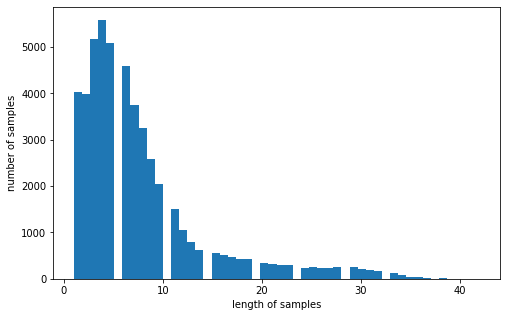

['굳 ㅋ', 'GDNTOPCLASSINTHECLUB', '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아']

코퍼스 문장수/평균/총 단어 갯수 : 49998, 7.6 / 380472
CPU times: user 4.85 s, sys: 200 ms, total: 5.05 s
Wall time: 6.18 s


In [1]:
%%time
## 1.2) read csv data
# NSMC 데이터 로드
import pandas as pd
# data_nsmc = pd.read_csv('data/nsmc.txt', sep='\t')
data_nsmc = pd.read_table('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_pair = [(row[1], row[2]) for _, row in data_nsmc.iterrows() if type(row[1]) == str]  # nan 제거
print(train_pair[:2])

#  문장 및 라벨 데이터 추출
train_data  = [pair[0] for pair in train_pair]
train_label = [pair[1] for pair in train_pair]
print('data loading done!')
print('sentence: %s' %(train_data[:3]))
print('Label   : %s' %(train_label[:3]))

num_word_list = [len(sentence.split()) for sentence in train_data]
print('\n코퍼스 문장수/평균/총 단어 갯수 : %d, %.1f / %d' % (len(num_word_list), sum(num_word_list)/len(num_word_list), sum(num_word_list)))

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(num_word_list, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# subword 학습을 위해 문장만 따로 저장
with open('train_tokenizer.txt', 'w', encoding='utf-8') as f:
    for line in train_data:
        f.write(line+'\n')

# subword 학습을 위해 문장만 따로 저장
with open('train_tokenizer.txt', 'r', encoding='utf-8') as f:
    test_tokenizer = f.read().split('\n')
print(test_tokenizer[:3])

num_word_list = [len(sentence.split()) for sentence in test_tokenizer]
print('\n코퍼스 문장수/평균/총 단어 갯수 : %d, %.1f / %d' % (len(num_word_list), sum(num_word_list)/len(num_word_list), sum(num_word_list)))

# SentencePiece 학습

In [2]:
!pip install sentencepiece==0.1.83

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 3.2 MB/s 


In [3]:
%%time

# spm_train --input=train_tokenizer.txt  --model_prefix=sentencepiece/sp --vocab_size=32000 character_coverage=1.0 --model_type="unigram"

import sentencepiece as spm
import os

input_file = 'train_tokenizer.txt'
vocab_size = 32000
sp_model_root='sentencepiece'
if not os.path.isdir(sp_model_root):
    os.mkdir(sp_model_root)
sp_model_name = 'tokenizer_%d' % (vocab_size)
sp_model_path = os.path.join(sp_model_root, sp_model_name)
model_type = 'unigram'  # 학습할 모델 선택, unigram이 더 성능이 좋음'bpe'
character_coverage  = 1.0  # 전체를 cover 하기 위해, default=0.9995
user_defined_symbols = '[PAD],[UNK],[CLS],[SEP],[MASK],[BOS],[EOS],[UNK0],[UNK1],[UNK2],[UNK3],[UNK4],[UNK5],[UNK6],[UNK7],[UNK8],[UNK9],[unused0],[unused1],[unused2],[unused3],[unused4],[unused5],[unused6],[unused7],[unused8],[unused9],[unused10],[unused11],[unused12],[unused13],[unused14],[unused15],[unused16],[unused17],[unused18],[unused19],[unused20],[unused21],[unused22],[unused23],[unused24],[unused25],[unused26],[unused27],[unused28],[unused29],[unused30],[unused31],[unused32],[unused33],[unused34],[unused35],[unused36],[unused37],[unused38],[unused39],[unused40],[unused41],[unused42],[unused43],[unused44],[unused45],[unused46],[unused47],[unused48],[unused49],[unused50],[unused51],[unused52],[unused53],[unused54],[unused55],[unused56],[unused57],[unused58],[unused59],[unused60],[unused61],[unused62],[unused63],[unused64],[unused65],[unused66],[unused67],[unused68],[unused69],[unused70],[unused71],[unused72],[unused73],[unused74],[unused75],[unused76],[unused77],[unused78],[unused79],[unused80],[unused81],[unused82],[unused83],[unused84],[unused85],[unused86],[unused87],[unused88],[unused89],[unused90],[unused91],[unused92],[unused93],[unused94],[unused95],[unused96],[unused97],[unused98],[unused99]'

input_argument = '--input=%s --model_prefix=%s --vocab_size=%s --user_defined_symbols=%s --model_type=%s --character_coverage=%s'
cmd = input_argument%(input_file, sp_model_path, vocab_size,user_defined_symbols, model_type, character_coverage)

spm.SentencePieceTrainer.Train(cmd)
print('train done')

train done
CPU times: user 20.6 s, sys: 252 ms, total: 20.9 s
Wall time: 15.8 s


In [4]:
## check
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format(sp_model_path))

tokens = sp.encode_as_pieces('나는 오늘 아침밥을 먹었다.')
ids = sp.encode_as_ids('나는 오늘 아침밥을 먹었다.')

print(ids)
print(tokens)

tokens = sp.decode_pieces(tokens)
ids = sp.decode_ids(ids)

print(ids)
print(tokens)

[422, 668, 5753, 5305, 131, 121, 9622, 120]
['▁나는', '▁오늘', '▁아침', '밥', '을', '▁', '먹었다', '.']
나는 오늘 아침밥을 먹었다.
나는 오늘 아침밥을 먹었다.


# Huggingface tokenizer

## 1. Huggingface setup

## 2. Huggingface train

In [5]:
!pip install tokenizers==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 5.2 MB/s 


In [6]:
%%time
from tokenizers import SentencePieceBPETokenizer, BertWordPieceTokenizer

how_to_tokenize = BertWordPieceTokenizer
# how_to_tokenize = SentencePieceBPETokenizer

# Initialize a tokenizer
if str(how_to_tokenize) == str(BertWordPieceTokenizer):
    print('BertWordPieceTokenizer')
    tokenizer = how_to_tokenize(
        strip_accents=False,  # Must be False if cased model
        lowercase=False,
    )
elif str(how_to_tokenize) == str(SentencePieceBPETokenizer):
    print('SentencePieceBPETokenizer')
    tokenizer = how_to_tokenize()
else:
    assert('select right tokenizer')

#########################################
corpus_file   = ['train_tokenizer.txt']  # data path
vocab_size    = 32000
limit_alphabet= 6000
output_path   = 'hugging_%d'%(vocab_size)

hf_model_root='huggingface'
if not os.path.isdir(hf_model_root):
    os.mkdir(hf_model_root)
hf_model_name = 'tokenizer_%d.json' % (vocab_size)
hf_model_path = os.path.join(hf_model_root, hf_model_name)

min_frequency = 5

## 1) define special tokens
user_defined_symbols = ['[BOS]','[EOS]','[UNK0]','[UNK1]','[UNK2]','[UNK3]','[UNK4]','[UNK5]','[UNK6]','[UNK7]','[UNK8]','[UNK9]']
unused_token_num = 20
unused_list = ['[unused{}]'.format(n) for n in range(unused_token_num)]
special_tokens = user_defined_symbols + unused_list
print(user_defined_symbols)


# Then train it!
tokenizer.train(files=corpus_file,
               vocab_size=vocab_size,
               min_frequency=min_frequency,  # 단어의 최소 발생 빈도, 5
               limit_alphabet=limit_alphabet,
               show_progress=True,
               special_tokens=special_tokens
               )

# And finally save it somewhere
tokenizer.save(hf_model_path)

output = tokenizer.encode("나는 오늘 아침밥을 먹었다.")
print('idx   : %s'%output.ids)
print('tokens: %s'%output.tokens)
print('offset: %s'%output.offsets)

output = tokenizer.encode("교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정")
print('idx   : %s'%output.ids)
print('tokens: %s'%output.tokens)
print('offset: %s'%output.offsets)

BertWordPieceTokenizer
['[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]']
idx   : [4761, 4937, 6312, 3432, 2404, 1041, 4405, 45]
tokens: ['나는', '오늘', '아침', '##밥', '##을', '먹', '##었다', '.']
offset: [(0, 2), (3, 5), (6, 8), (8, 9), (9, 10), (11, 12), (12, 14), (14, 15)]
idx   : [13943, 4497, 13513, 45, 45, 4645, 5424, 4471, 45, 45, 4388, 15204]
tokens: ['교도소', '이야기', '##구먼', '.', '.', '솔직히', '재미는', '없다', '.', '.', '평점', '조정']
offset: [(0, 3), (4, 7), (7, 9), (10, 11), (11, 12), (12, 15), (16, 19), (20, 22), (22, 23), (23, 24), (24, 26), (27, 29)]
CPU times: user 5.81 s, sys: 1.33 s, total: 7.14 s
Wall time: 6.41 s


## 3. Huggingface Tokenize test

In [7]:
from tokenizers import Tokenizer

how_to_tokenize = BertWordPieceTokenizer
# how_to_tokenize = SentencePieceBPETokenizer
vocab_size    = 32000

tokenizer = Tokenizer.from_file(hf_model_path)


output = tokenizer.encode("나는 오늘 아침밥을 먹었다.")
print('idx   : %s'%output.ids)
print('tokens: %s'%output.tokens)
print('offset: %s'%output.offsets)

output = tokenizer.encode("교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정")
print('idx   : %s'%output.ids)
print('tokens: %s'%output.tokens)
print('offset: %s'%output.offsets)

idx   : [4761, 4937, 6312, 3432, 2404, 1041, 4405, 45]
tokens: ['나는', '오늘', '아침', '##밥', '##을', '먹', '##었다', '.']
offset: [(0, 2), (3, 5), (6, 8), (8, 9), (9, 10), (11, 12), (12, 14), (14, 15)]
idx   : [13943, 4497, 13513, 45, 45, 4645, 5424, 4471, 45, 45, 4388, 15204]
tokens: ['교도소', '이야기', '##구먼', '.', '.', '솔직히', '재미는', '없다', '.', '.', '평점', '조정']
offset: [(0, 3), (4, 7), (7, 9), (10, 11), (11, 12), (12, 15), (16, 19), (20, 22), (22, 23), (23, 24), (24, 26), (27, 29)]


# Tokenze usage

## 1. SentencePiece Usage, load & 분절

In [8]:
%%time
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format(sp_model_path))
sentencepiece_tokenizer = sp.encode_as_pieces

result_tokenized_sentencepiece = [sentencepiece_tokenizer(_tmp) for _tmp in test_tokenizer[:3]]
    
for tmp in result_tokenized_sentencepiece[:3]:
    print(tmp)

['▁굳', '▁ᄏ']
['▁G', 'D', 'N', 'T', 'O', 'P', 'CL', 'A', 'SS', 'IN', 'THE', 'CL', 'U', 'B']
['▁뭐야', '▁이', '▁평점', '들은', '....', '▁나쁘진', '▁않지만', '▁10', '점', '▁짜리', '는', '▁더더욱', '▁아니잖아']
CPU times: user 186 ms, sys: 1.89 ms, total: 187 ms
Wall time: 254 ms


## 2. Huggingface Usage, load & 분절

In [9]:
%%time
from tokenizers import Tokenizer

how_to_tokenize = BertWordPieceTokenizer
# how_to_tokenize = SentencePieceBPETokenizer
vocab_size    = 32000

tokenizer = Tokenizer.from_file(hf_model_path)

result_tokenized_sentencepiece = [tokenizer.encode(_tmp).tokens for _tmp in test_tokenizer[:3]]
for tmp in result_tokenized_sentencepiece[:3]:
    print(tmp)


['굳', 'ㅋ']
['G', '##D', '##N', '##T', '##O', '##P', '##C', '##L', '##A', '##S', '##S', '##IN', '##T', '##H', '##EC', '##L', '##U', '##B']
['뭐야', '이', '평점들', '##은', '.', '.', '.', '.', '나쁘진', '않지만', '10점', '짜리', '##는', '더더욱', '아니잖아']
CPU times: user 29.7 ms, sys: 1.98 ms, total: 31.7 ms
Wall time: 33.4 ms
